[View in Colaboratory](https://colab.research.google.com/github/fortesit/Kaggle-Santander-Value-Prediction-Challenge/blob/master/mnist_bootcamp.ipynb)

# Download data

In [1]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Data loaded")
print("Shape:{}".format(x_train.shape))

x_train = np.expand_dims(x_train, axis=-1).astype('float32')
y_train = y_train.astype('int32')
x_test = np.expand_dims(x_test, axis=-1).astype('float32')
y_test = y_test.astype('int32')
print("Shape:{}".format(x_train.shape))

11501568/11490434 [==============================] - 0s 0us/step
Data loaded
Shape:(60000, 28, 28)
Shape:(60000, 28, 28, 1)


# Visualize data

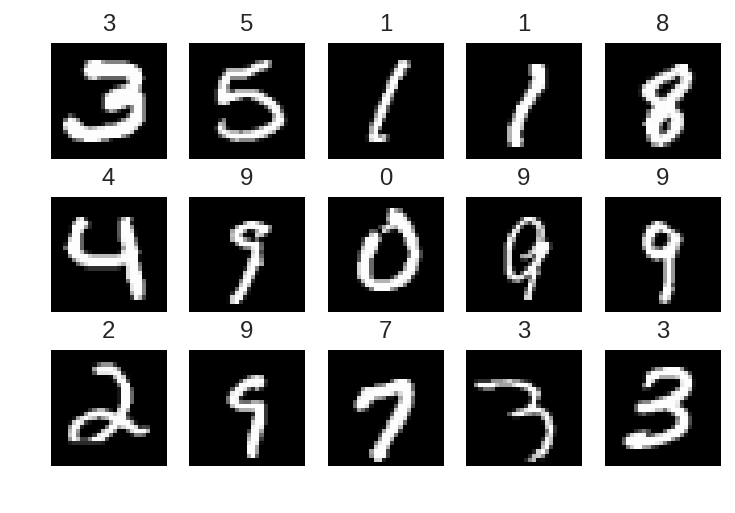

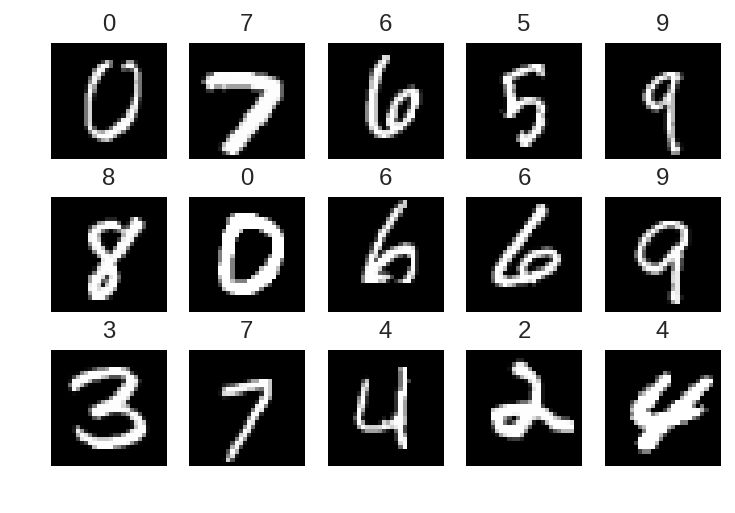

In [2]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_mnist(x, y):
    plt.figure()
    for i in range(15):
        plt.subplot(3, 5, i+1)
        index = random.randint(0, x.shape[0])
        plt.title(str(y[index]))
        plt.imshow(x[index][:,:,0], cmap='gray')
        plt.axis('off')

show_mnist(x_train, y_train)
show_mnist(x_test, y_test)

# Define CNN Model

In [0]:
def core_model():
  """Model to recognize digits in the MNIST dataset.

  Returns:
    A tf.keras.Model.
  """

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu),
      tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(128, 3, activation=tf.nn.relu),
      tf.keras.layers.Conv2D(256, 3, activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)
  ])
  
  return model

# Define model function

Required by Estimator.
It can return types of models for different senerio, e.x. train, predict, evaluation

In [0]:
def model_fn(features, labels, mode):
  """The model_fn argument for creating an Estimator."""
  model = core_model()
  image = features
  if isinstance(image, dict):
    image = features['image']

  # Model just for Predict
  if mode == tf.estimator.ModeKeys.PREDICT:
    logits = model(image, training=False)
    predictions = {
        'classes': tf.argmax(logits, axis=1),
        'probabilities': tf.nn.softmax(logits),
    }
    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.PREDICT,
        predictions=predictions,
        export_outputs={
            'classify': tf.estimator.export.PredictOutput(predictions)
        })
  
  # Model with Train Operators
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer()

    logits = model(image, training=True)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    accuracy = tf.metrics.accuracy(
        labels=labels, predictions=tf.argmax(logits, axis=1))

    # Name tensors to be logged with LoggingTensorHook.
    tf.identity(loss, 'cross_entropy')
    tf.identity(accuracy[1], name='train_accuracy')

    # Save accuracy scalar to Tensorboard output.
    tf.summary.scalar('train_accuracy', accuracy[1])

    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.TRAIN,
        loss=loss,
        train_op=optimizer.minimize(loss, tf.train.get_or_create_global_step()))
  
  # Model with Eval Operators
  if mode == tf.estimator.ModeKeys.EVAL:
    logits = model(image, training=False)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.EVAL,
        loss=loss,
        eval_metric_ops={
            'accuracy':
                tf.metrics.accuracy(
                    labels=labels, predictions=tf.argmax(logits, axis=1)),
        })

# Train and eval

In [5]:
# Set up training and evaluation input functions.
def train_input_fn():
  """Prepare data for training."""
  dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  dataset = dataset.shuffle(buffer_size=1000)
  dataset = dataset.repeat(2)
  dataset = dataset.batch(64)
  iterator = dataset.make_one_shot_iterator()
  return iterator.get_next()

def eval_input_fn():
  """Prepare data for test."""
  dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  dataset = dataset.batch(64)
  iterator = dataset.make_one_shot_iterator()
  return iterator.get_next()
  
def train_eval():
  mnist_classifier = tf.estimator.Estimator(model_fn=model_fn)

  # Set up hook that outputs training logs every 1000 steps.
  train_hooks = [
      tf.train.LoggingTensorHook(
          tensors=dict(
              (x, x)
              for x in ['cross_entropy', 'train_accuracy']),
          every_n_iter=1000)
  ]

  # Train and evaluate model.
  mnist_classifier.train(input_fn=train_input_fn) #, hooks=train_hooks)
  eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
  print('Evaluation results:\n\t{}\n'.format(eval_results))

train_eval()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff735756c90>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpXRFeGm', '_train_distribute': None, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpXRFeGm/model.ckpt.
INFO:tensorf